#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [213]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [214]:
path = '/content/drive/MyDrive/KTaivle/6차미니프로젝트/'

### **(2) 라이브러리 설치 및 불러오기**

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [216]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [217]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [218]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [219]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [220]:
df = pd.merge(sales, products, on='Product_ID')

In [221]:
df_3 = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 3)]
df_12 = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 12)]
df_42 = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 42)]

## **(2) 상품 : 12 - Milk**

In [222]:
df_12

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
373291,2014-01-01,44,0.0,12,GA001,Milk,Food,2,6
373345,2014-01-02,44,9647.0,12,GA001,Milk,Food,2,6
373399,2014-01-03,44,8879.0,12,GA001,Milk,Food,2,6
373453,2014-01-04,44,14188.0,12,GA001,Milk,Food,2,6
373507,2014-01-05,44,14490.0,12,GA001,Milk,Food,2,6
...,...,...,...,...,...,...,...,...,...
435229,2017-02-24,44,10630.0,12,GA001,Milk,Food,2,6
435283,2017-02-25,44,12978.0,12,GA001,Milk,Food,2,6
435337,2017-02-26,44,10899.0,12,GA001,Milk,Food,2,6
435391,2017-02-27,44,10618.0,12,GA001,Milk,Food,2,6


In [223]:
state_df = pd.merge(df, stores, on='Store_ID')

In [224]:
state_df_milk = state_df[state_df['Product_ID'] == 12]

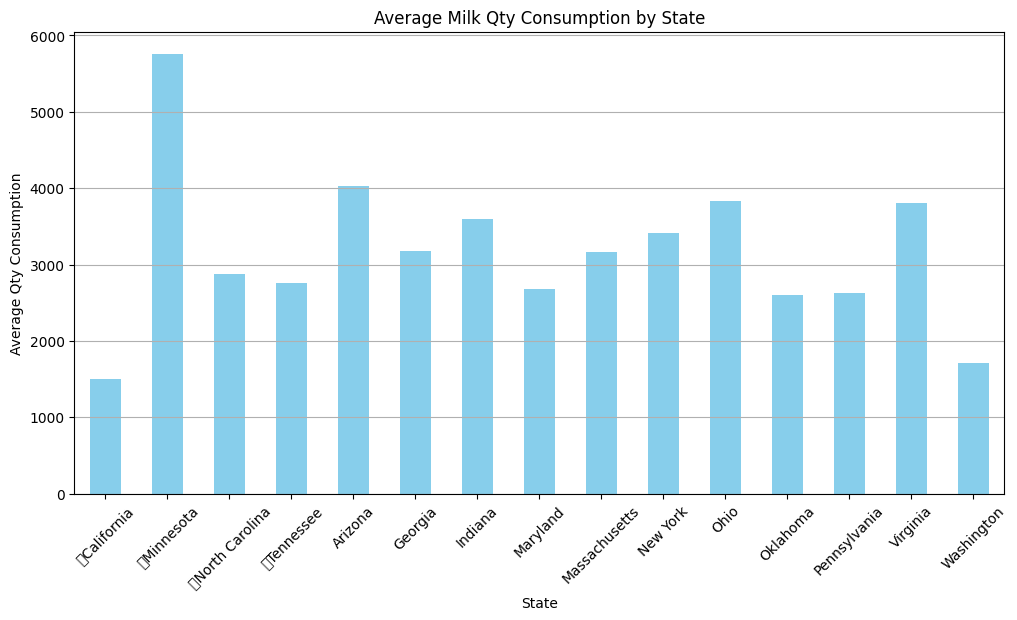

In [225]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
state_df_milk.groupby('State')['Qty'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Milk Qty Consumption by State')
plt.xlabel('State')
plt.ylabel('Average Qty Consumption')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [226]:
df_12_season = df_12.copy()

df_12_season['Season'] = df_12_season['Date'].dt.month.apply(lambda x: 'Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else ('Autumn' if x in [9, 10, 11] else 'Winter')))

In [227]:
df_12_season

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Season
373291,2014-01-01,44,0.0,12,GA001,Milk,Food,2,6,Winter
373345,2014-01-02,44,9647.0,12,GA001,Milk,Food,2,6,Winter
373399,2014-01-03,44,8879.0,12,GA001,Milk,Food,2,6,Winter
373453,2014-01-04,44,14188.0,12,GA001,Milk,Food,2,6,Winter
373507,2014-01-05,44,14490.0,12,GA001,Milk,Food,2,6,Winter
...,...,...,...,...,...,...,...,...,...,...
435229,2017-02-24,44,10630.0,12,GA001,Milk,Food,2,6,Winter
435283,2017-02-25,44,12978.0,12,GA001,Milk,Food,2,6,Winter
435337,2017-02-26,44,10899.0,12,GA001,Milk,Food,2,6,Winter
435391,2017-02-27,44,10618.0,12,GA001,Milk,Food,2,6,Winter


In [228]:
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')

In [229]:
df_12_season_oil = pd.merge(df_12_season, oil_price, on='Date')

In [230]:
df_12_season_oil

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Season,WTI_Price
0,2014-01-01,44,0.0,12,GA001,Milk,Food,2,6,Winter,95.14
1,2014-01-02,44,9647.0,12,GA001,Milk,Food,2,6,Winter,95.14
2,2014-01-03,44,8879.0,12,GA001,Milk,Food,2,6,Winter,93.66
3,2014-01-06,44,7614.0,12,GA001,Milk,Food,2,6,Winter,93.12
4,2014-01-07,44,7124.0,12,GA001,Milk,Food,2,6,Winter,93.31
...,...,...,...,...,...,...,...,...,...,...,...
818,2017-02-22,44,8931.0,12,GA001,Milk,Food,2,6,Winter,53.61
819,2017-02-23,44,8643.0,12,GA001,Milk,Food,2,6,Winter,54.48
820,2017-02-24,44,10630.0,12,GA001,Milk,Food,2,6,Winter,53.99
821,2017-02-27,44,10618.0,12,GA001,Milk,Food,2,6,Winter,54.04


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [231]:
df_12_season = df_12.copy()

df_12_season['Season'] = df_12_season['Date'].dt.month.apply(lambda x: 'Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else ('Autumn' if x in [9, 10, 11] else 'Winter')))
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')
df_12_season_oil = pd.merge(df_12_season, oil_price, on='Date')
df_12_season_oil.drop(columns=['Product_ID', 'Store_ID', 'Product_Code', 'SubCategory', 'Category', 'LeadTime', 'Price'], inplace=True)

In [232]:
df_12_season_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       823 non-null    datetime64[ns]
 1   Qty        823 non-null    float64       
 2   Season     823 non-null    object        
 3   WTI_Price  823 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 25.8+ KB


In [233]:
df_12_season_oil_final = df_12_season_oil.copy()

df_12_season_oil_final['Year'] = df_12_season_oil_final['Date'].dt.year
df_12_season_oil_final['Month'] = df_12_season_oil_final['Date'].dt.month
df_12_season_oil_final['Day'] = df_12_season_oil_final['Date'].dt.day

df_12_season_oil_final_encoded = pd.get_dummies(df_12_season_oil_final['Season'])
df_12_season_oil_final = pd.concat([df_12_season_oil_final, df_12_season_oil_final_encoded], axis=1)
df_12_season_oil_final.drop(columns=['Season', 'Date'], inplace=True)

df_12_season_oil_final

,Qty,WTI_Price,Year,Month,Day,Autumn,Spring,Summer,Winter
0,0.0,95.14,2014,1,1,False,False,False,True
1,9647.0,95.14,2014,1,2,False,False,False,True
2,8879.0,93.66,2014,1,3,False,False,False,True
3,7614.0,93.12,2014,1,6,False,False,False,True
4,7124.0,93.31,2014,1,7,False,False,False,True
...,...,...,...,...,...,...,...,...,...
818,8931.0,53.61,2017,2,22,False,False,False,True
819,8643.0,54.48,2017,2,23,False,False,False,True
820,10630.0,53.99,2017,2,24,False,False,False,True
821,10618.0,54.04,2017,2,27,False,False,False,True


In [258]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_12_season_oil_final[['Year', 'Month', 'Day', 'Winter', 'Spring', 'Summer', 'Autumn', 'WTI_Price', 'Qty']])

In [259]:
val_size = 60
train_size = len(scaled_data) - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:]

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]

### **2) 모델링**

In [261]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense

model_12 = Sequential()
model_12.add(Dense(1, input_dim=X_train.shape[1], activation='linear'))

model_12.compile(loss='mean_squared_error', optimizer='adam')

history_12 = model_12.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=0)

In [262]:
y_pred = model_12.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R2 Score:", r2)

2/2 [==============================] - 0s 12ms/step
Mean Squared Error (MSE): 0.07658388443452803
Mean Absolute Percentage Error (MAPE): 75.50862909994768
R2 Score: -9.44594265960134


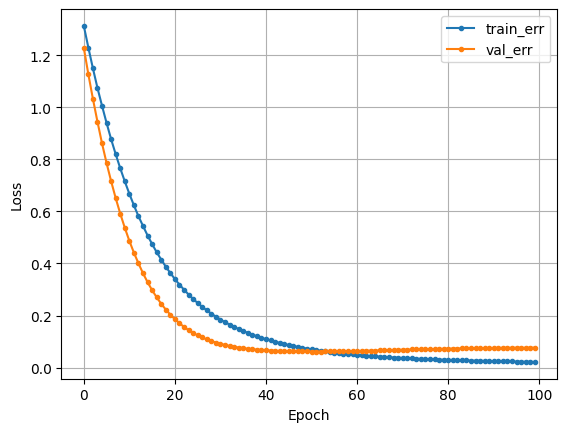

In [263]:
dl_history_plot(history_12.history)

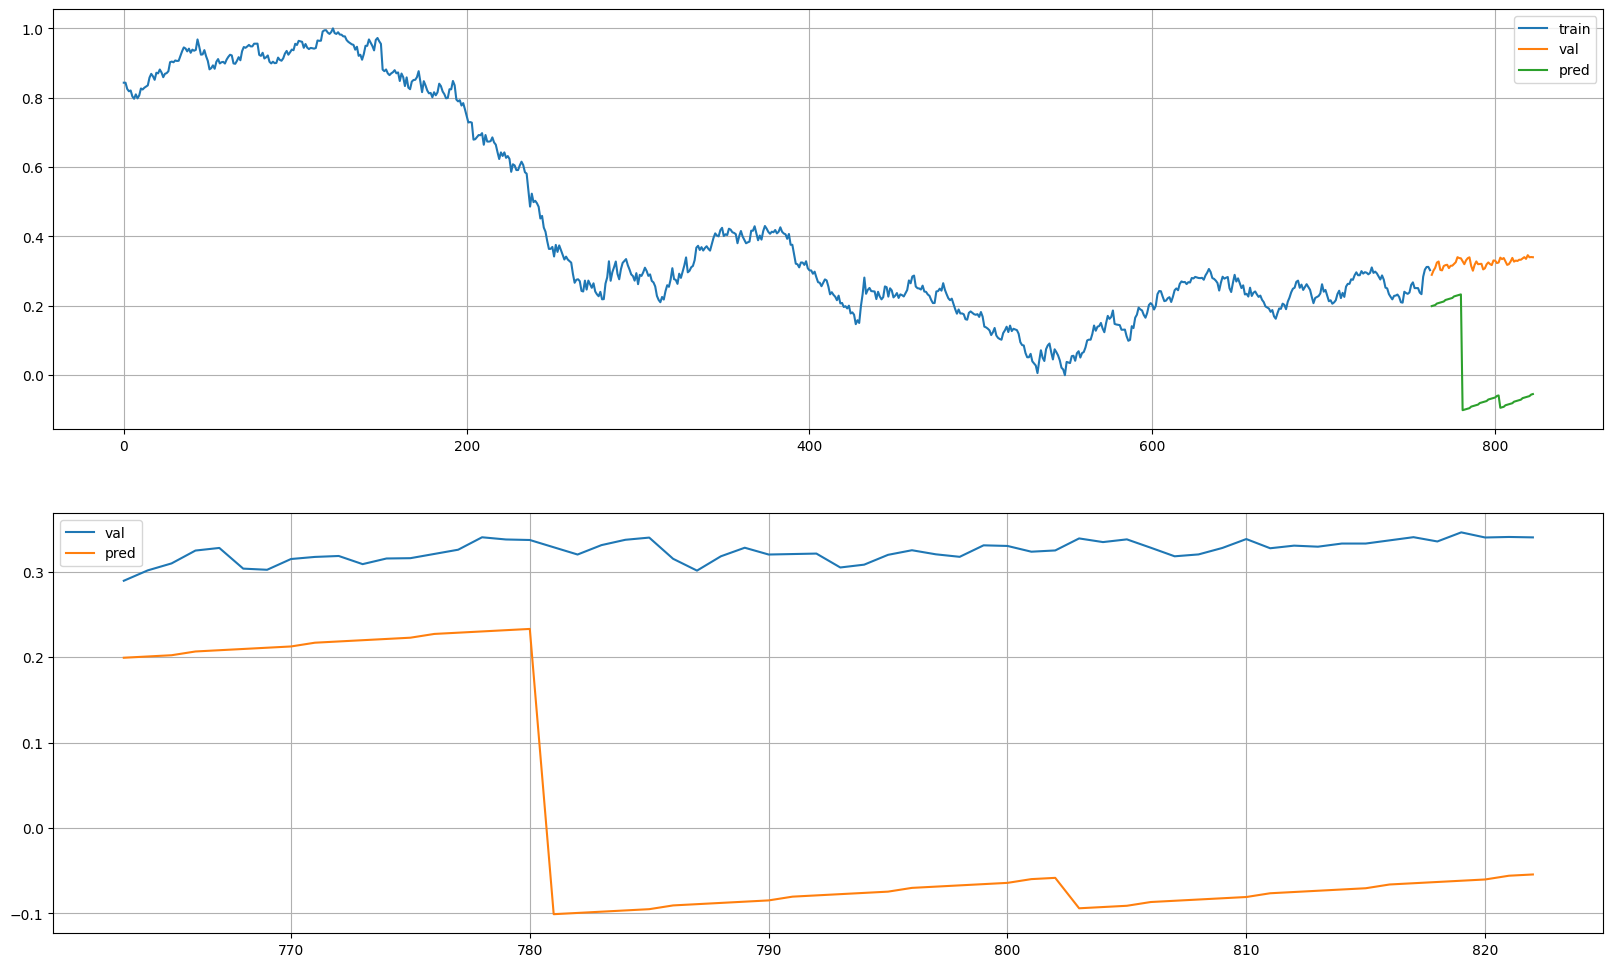

In [238]:
plot_model_result(y_train, y_val, y_pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [245]:
# def temporalize(x, y, timesteps):
#     output_X = []
#     output_y = []
#     for i in range(len(x) - timesteps + 1):
#         output_X.append(x.iloc[i:i+timesteps])
#         output_y.append(y.iloc[i+timesteps-1])
#     return np.array(output_X), np.array(output_y)

def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x[i:i+timesteps, :-1])
        output_y.append(y[i+timesteps-1, -1])
    return np.array(output_X), np.array(output_y)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [267]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Conv1D, MaxPooling1D

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_12_season_oil_final[['WTI_Price', 'Year', 'Month', 'Day', 'Autumn', 'Spring', 'Summer', 'Winter', 'Qty']])

train_size = df_12_season_oil_final.shape[0] - 60
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:]

timesteps = 7
X_train, y_train = temporalize(train_data, train_data, timesteps)
X_val, y_val = temporalize(val_data, val_data, timesteps)


* **모델링**

In [247]:
# LSTM 모델 생성 함수
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(1))
    return model

In [273]:
lstm_model = create_lstm_model(X_train.shape[1:])
lstm_model.compile(optimizer='adam', loss='mse')
history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0)

In [269]:
lstm_y_pred = lstm_model.predict(X_val)

mse = mean_squared_error(y_val, lstm_y_pred)
mape = np.mean(np.abs((y_val - lstm_y_pred) / y_val)) * 100
r2 = r2_score(y_val, lstm_y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R2 Score:", r2)

2/2 [==============================] - 1s 12ms/step
Mean Squared Error (MSE): 0.005581753601832296
Mean Absolute Percentage Error (MAPE): 21.507718910351706
R2 Score: 0.21934124044842784


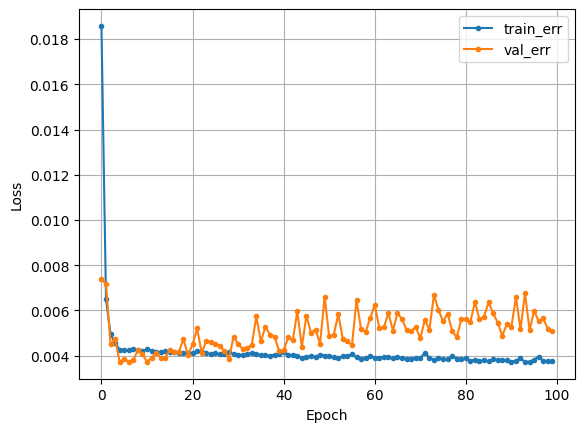

In [274]:
dl_history_plot(history_lstm.history)

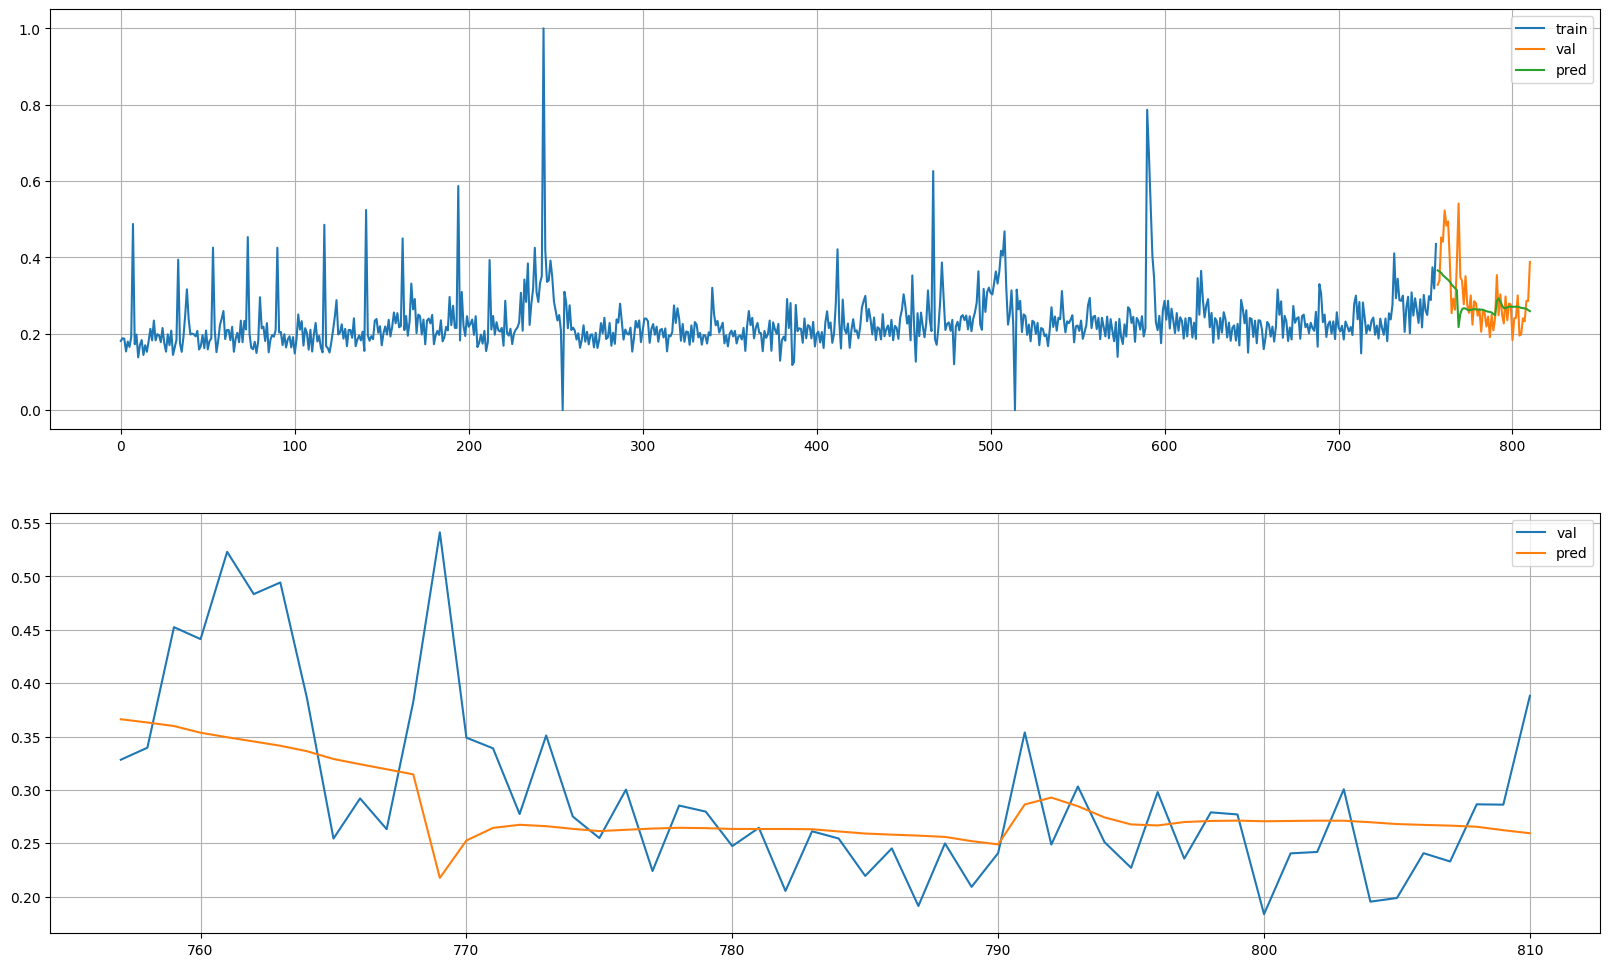

In [272]:
plot_model_result(y_train, y_val, lstm_y_pred)

## **(2) CNN 초기 모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [251]:
# CNN 모델 생성 함수
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    return model

* **모델링**

In [256]:
# CNN 모델 생성 및 학습
cnn_model = create_cnn_model(X_train.shape[1:])
cnn_model.compile(optimizer='adam', loss='mse')
history_cnn = cnn_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0)

In [276]:
cnn_y_pred = cnn_model.predict(X_val)

mse = mean_squared_error(y_val, cnn_y_pred)
mape = np.mean(np.abs((y_val - cnn_y_pred) / y_val)) * 100
r2 = r2_score(y_val, cnn_y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R2 Score:", r2)

2/2 [==============================] - 0s 9ms/step
Mean Squared Error (MSE): 0.004787334900434998
Mean Absolute Percentage Error (MAPE): 22.352526703178167
R2 Score: 0.3304478858212736


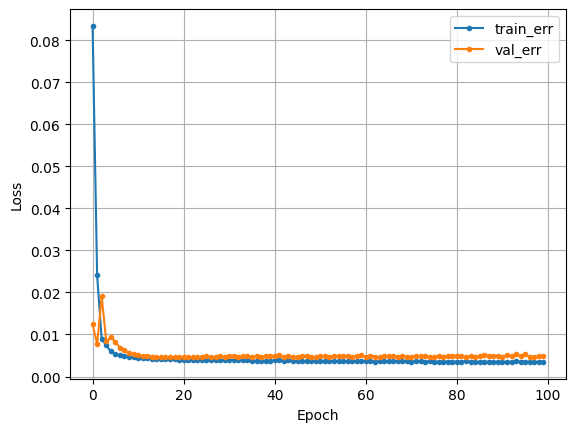

In [277]:
dl_history_plot(history_cnn.history)

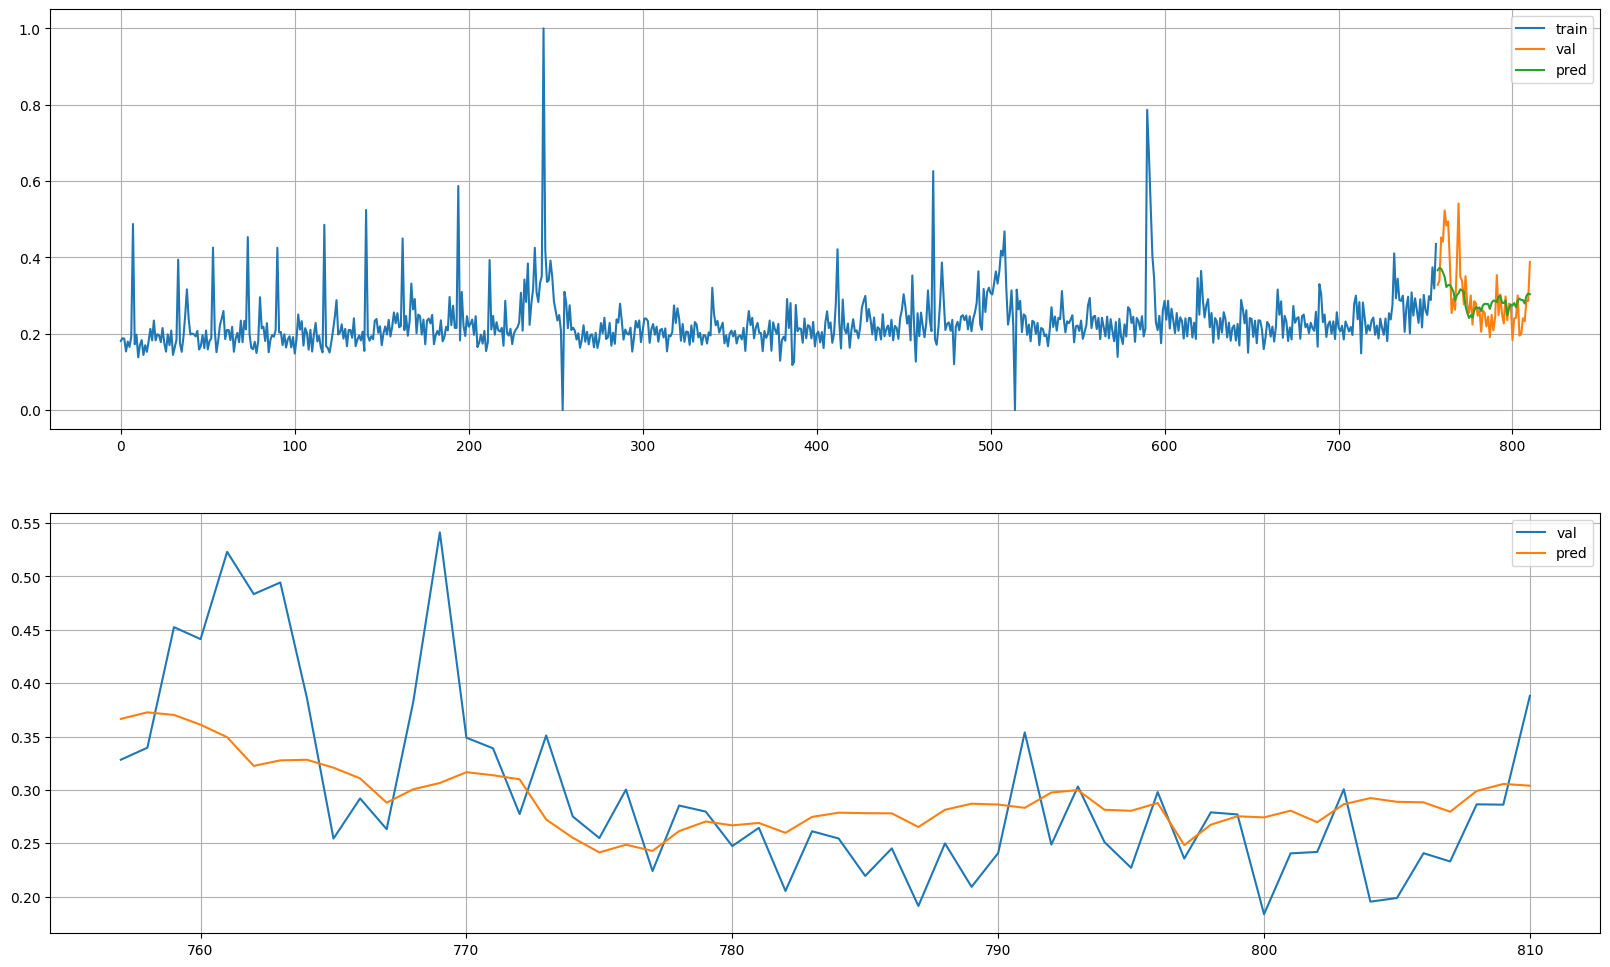

In [278]:
plot_model_result(y_train, y_val, cnn_y_pred)